# Section 5.5 — Hierarchical models

This notebook contains the code examples from [Section 5.5 Hierarchical models]() from the **No Bullshit Guide to Statistics**.

See also:
- [03_hierarchical_model.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/03_hierarchical_model.ipynb)
- https://github.com/fonnesbeck/pymc_sdss_2024/blob/main/notebooks/Section4-Hierarchical_Models.ipynb
- 

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayes/hierarchical"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Definitions

## Model

## Explanations

## Discussion

## Exercises

## Links

## EXTRA MATERIAL

### Radon levels

cf. https://github.com/mitzimorris/brms_feb_28_2023/blob/main/brms_notebook.Rmd

In [4]:
radon = pd.read_csv("../datasets/radon.csv")
# radon["county_id"] = radon["county_id"].astype('category')
radon

,floor,county,log_radon,log_uranium,county_id
0,1,AITKIN,0.788457,-0.689048,1
1,0,AITKIN,0.788457,-0.689048,1
2,0,AITKIN,1.064711,-0.689048,1
3,0,AITKIN,0.000000,-0.689048,1
4,0,ANOKA,1.131402,-0.847313,2
...,...,...,...,...,...
914,0,WRIGHT,1.856298,-0.090024,84
915,0,WRIGHT,1.504077,-0.090024,84
916,0,WRIGHT,1.609438,-0.090024,84
917,0,YELLOW MEDICINE,1.308333,0.355287,85


In [5]:
import bambi as bmb

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Complete pooling

In [6]:
mod_cp = bmb.Model("log_radon ~ 1 + C(floor)", data=radon)

In [7]:
mod_cp

       Formula: log_radon ~ 1 + C(floor)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2246, sigma: 2.3354)
            C(floor) ~ Normal(mu: 0.0, sigma: 5.7237)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8529)

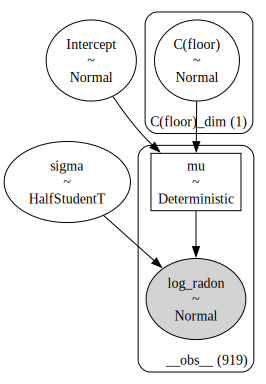

In [8]:
mod_cp.build()
mod_cp.graph()

In [9]:
idata_cp = mod_cp.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, C(floor)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [10]:
import arviz as az

az.summary(idata_cp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
C(floor)[1],-0.614,0.074,-0.749,-0.472,0.001,0.001,6615.0,2710.0,1.0
Intercept,1.327,0.030,1.269,1.382,0.000,0.000,5416.0,3122.0,1.0
sigma,0.823,0.020,0.785,0.859,0.000,0.000,6580.0,3132.0,1.0


/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: floor


(<Figure size 500x300 with 1 Axes>,
 array([<Axes: xlabel='floor', ylabel='log_radon'>], dtype=object))

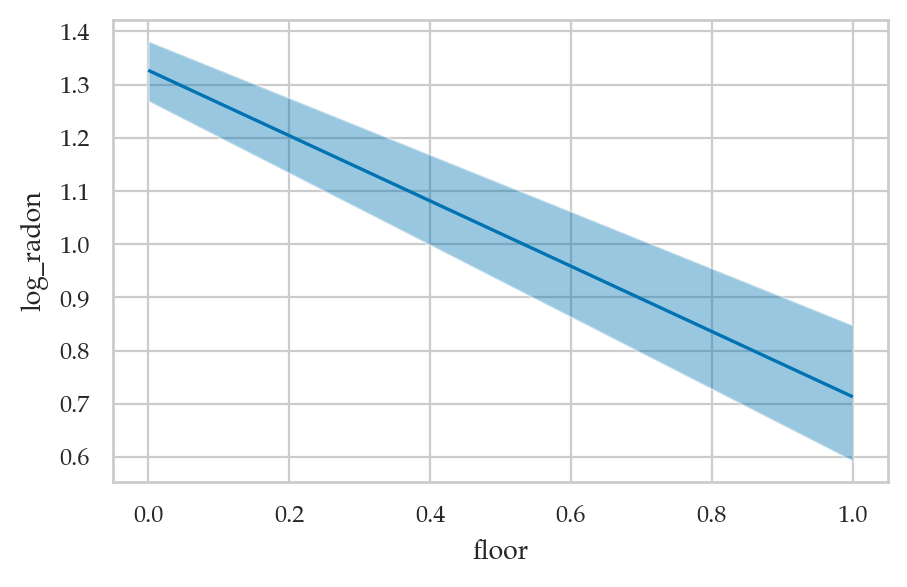

In [11]:
bmb.interpret.plot_predictions(mod_cp, idata_cp, "floor")

### No pooling

In [12]:
mod_np = bmb.Model("log_radon ~ 1 + C(floor) + C(county_id)", data=radon)
# mod_np

In [13]:
idata_np = mod_np.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, C(floor), C(county_id)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: floor, county_id


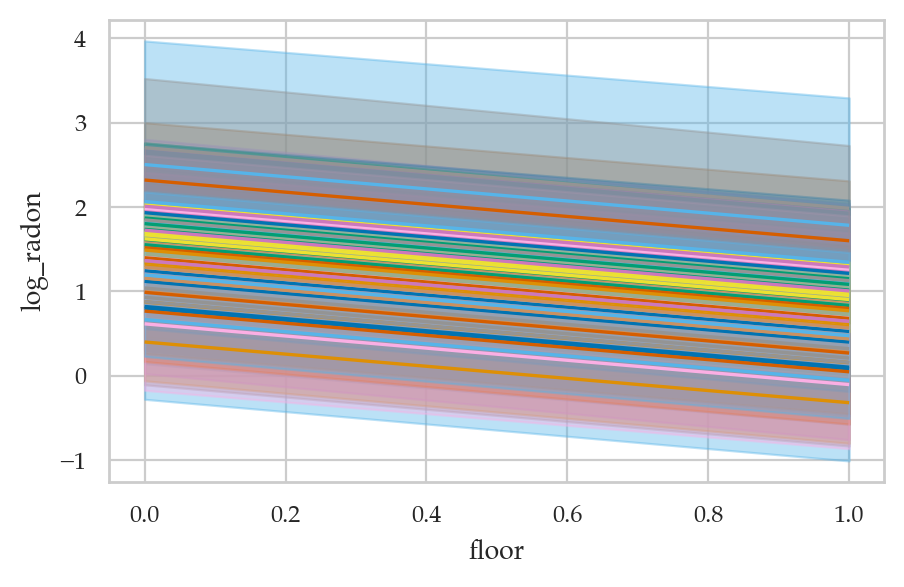

In [14]:
fig, axs = bmb.interpret.plot_predictions(mod_np, idata_np, ["floor", "county_id"]);
axs[0].get_legend().remove()

### Partial Pooling Model: varying slope

The partial pooling formula estimates per-county intercepts which drawn
from the same distribution which is estimated jointly with the rest of
the model parameters. The `1` is the intercept co-efficient. The
estimates across counties will all have the same slope.


    log_radon ~ floor + (1 | county_id)


In [15]:
mod_pp1 = bmb.Model("log_radon ~ (1 | C(county_id)) + C(floor)", data=radon)
mod_pp1

       Formula: log_radon ~ (1 | C(county_id)) + C(floor)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2246, sigma: 2.3354)
            C(floor) ~ Normal(mu: 0.0, sigma: 5.7237)
        
        Group-level effects
            1|C(county_id) ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.3354))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8529)

In [16]:
idata_pp1 = mod_pp1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, C(floor), 1|C(county_id)_sigma, 1|C(county_id)_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

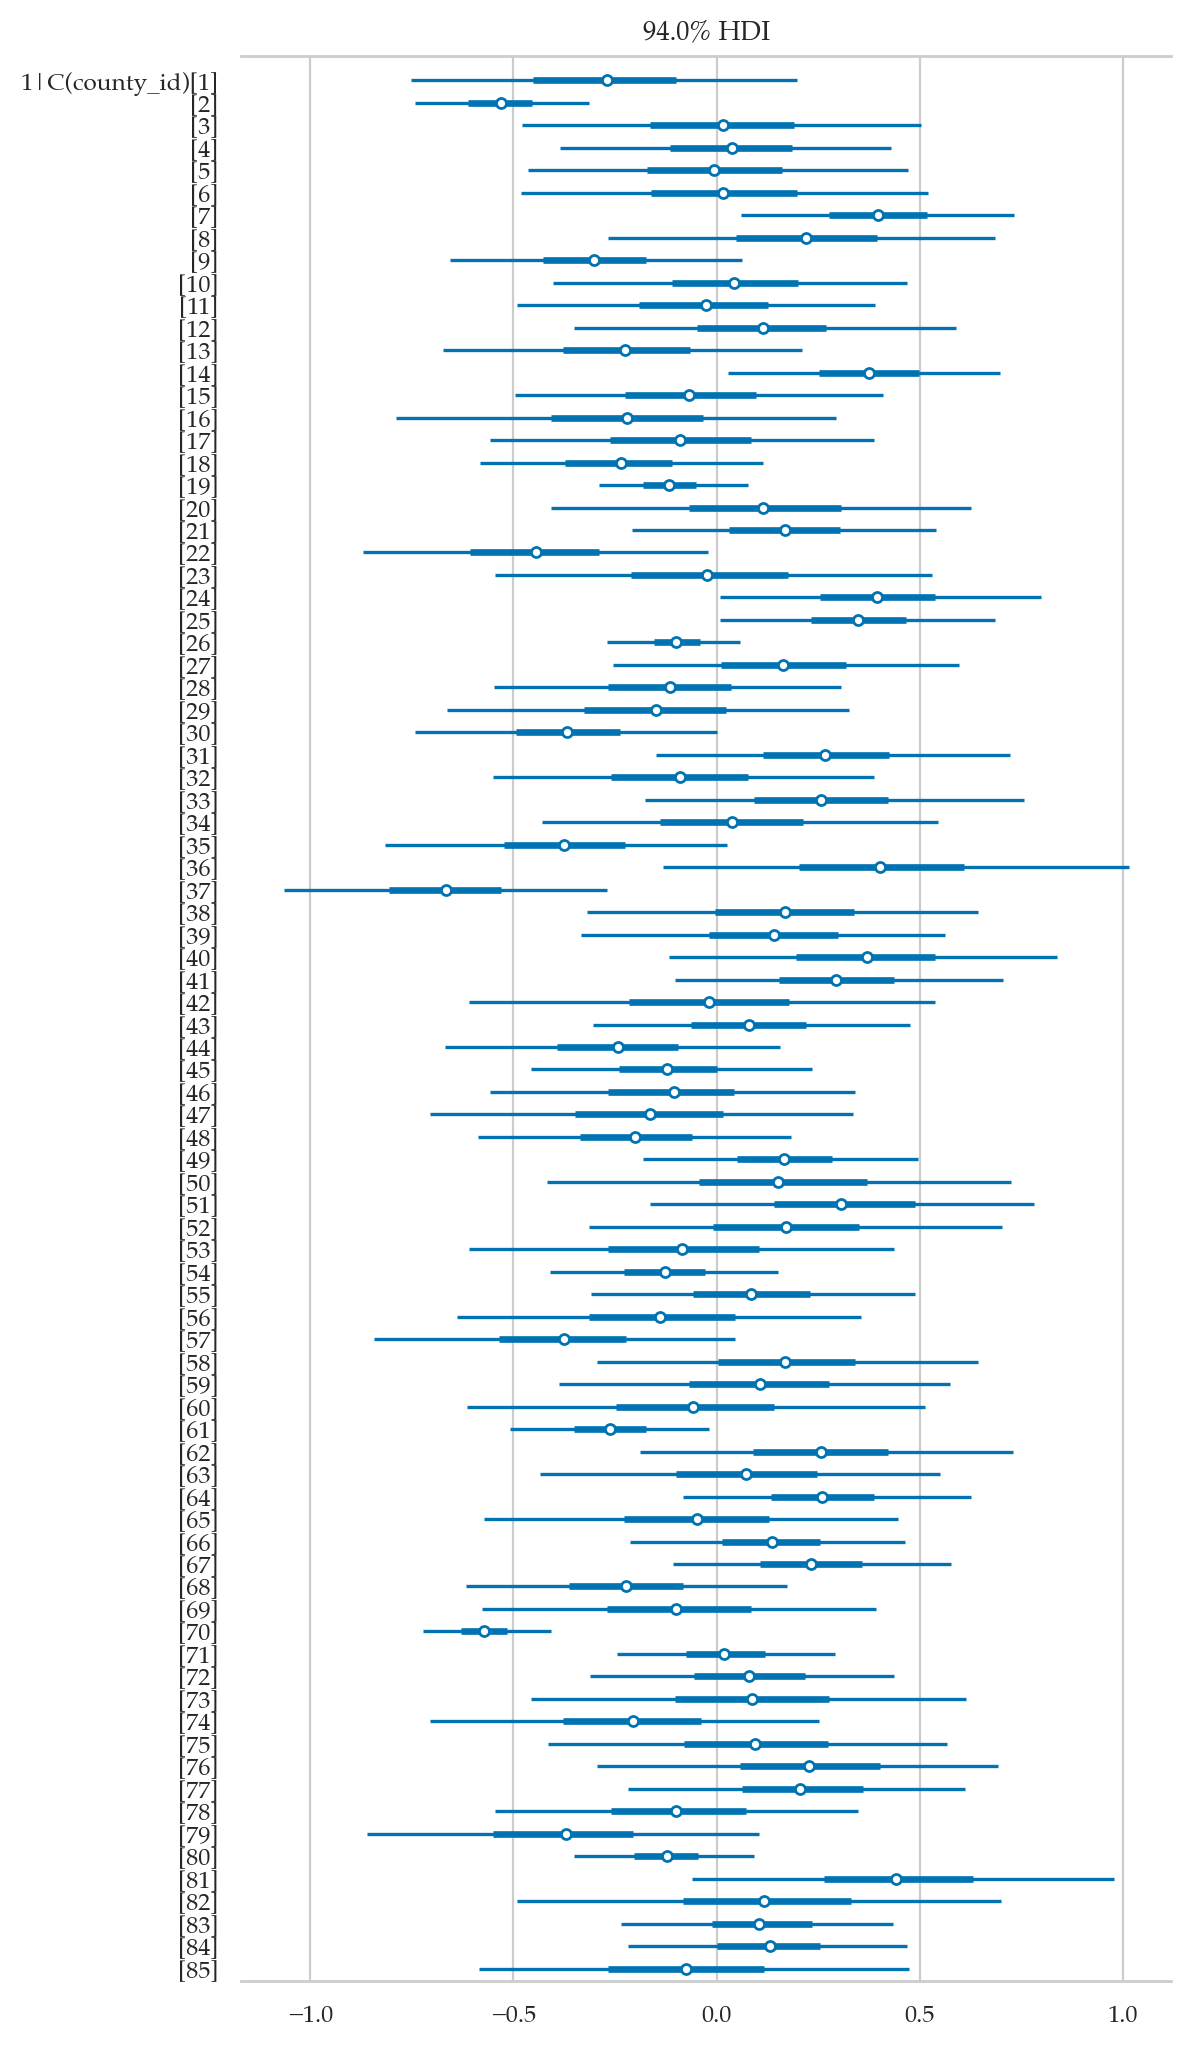

In [17]:
az.plot_forest(idata_pp1, var_names=["1|C(county_id)"], combined=True)

### Partial Pooling Model 2: varying slope, varying intercept

The varying-slope, varying intercept model adds `floor` to the
group-level co-efficients. Now estimates across counties will all have
varying slope.

    log_radon ~ floor + (1 + floor | county_id)

In [18]:
mod_pp2 = bmb.Model("log_radon ~ (1 + C(floor) | C(county_id))", data=radon)
mod_pp2

       Formula: log_radon ~ (1 + C(floor) | C(county_id))
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2246, sigma: 2.1322)
        
        Group-level effects
            1|C(county_id) ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.1322))
            C(floor)|C(county_id) ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.7237))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8529)

In [19]:
idata_pp2 = mod_pp2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|C(county_id)_sigma, 1|C(county_id)_offset, C(floor)|C(county_id)_sigma, C(floor)|C(county_id)_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [20]:
idata_pp2.posterior

<xarray.Dataset> Size: 6MB
Dimensions:                      (chain: 4, draw: 1000,
                                  C(county_id)__factor_dim: 85,
                                  C(floor)__expr_dim: 1)
Coordinates:
  * chain                        (chain) int64 32B 0 1 2 3
  * draw                         (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * C(county_id)__factor_dim     (C(county_id)__factor_dim) <U2 680B '1' ... ...
  * C(floor)__expr_dim           (C(floor)__expr_dim) <U1 4B '1'
Data variables:
    1|C(county_id)               (chain, draw, C(county_id)__factor_dim) float64 3MB ...
    1|C(county_id)_sigma         (chain, draw) float64 32kB 0.412 ... 0.3155
    C(floor)|C(county_id)        (chain, draw, C(floor)__expr_dim, C(county_id)__factor_dim) float64 3MB ...
    C(floor)|C(county_id)_sigma  (chain, draw, C(floor)__expr_dim) float64 32kB ...
    Intercept                    (chain, draw) float64 32kB 1.39 1.392 ... 1.396
    sigma                        (chain, draw) float64 32kB 0.754 ... 0.7576
Attributes:
    created_at:                  2024-11-29T16:29:00.079445+00:00
    arviz_version:               0.19.0
    inference_library:           pymc
    inference_library_version:   5.18.0
    sampling_time:               7.335843086242676
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.14.1.dev12+g3a30784

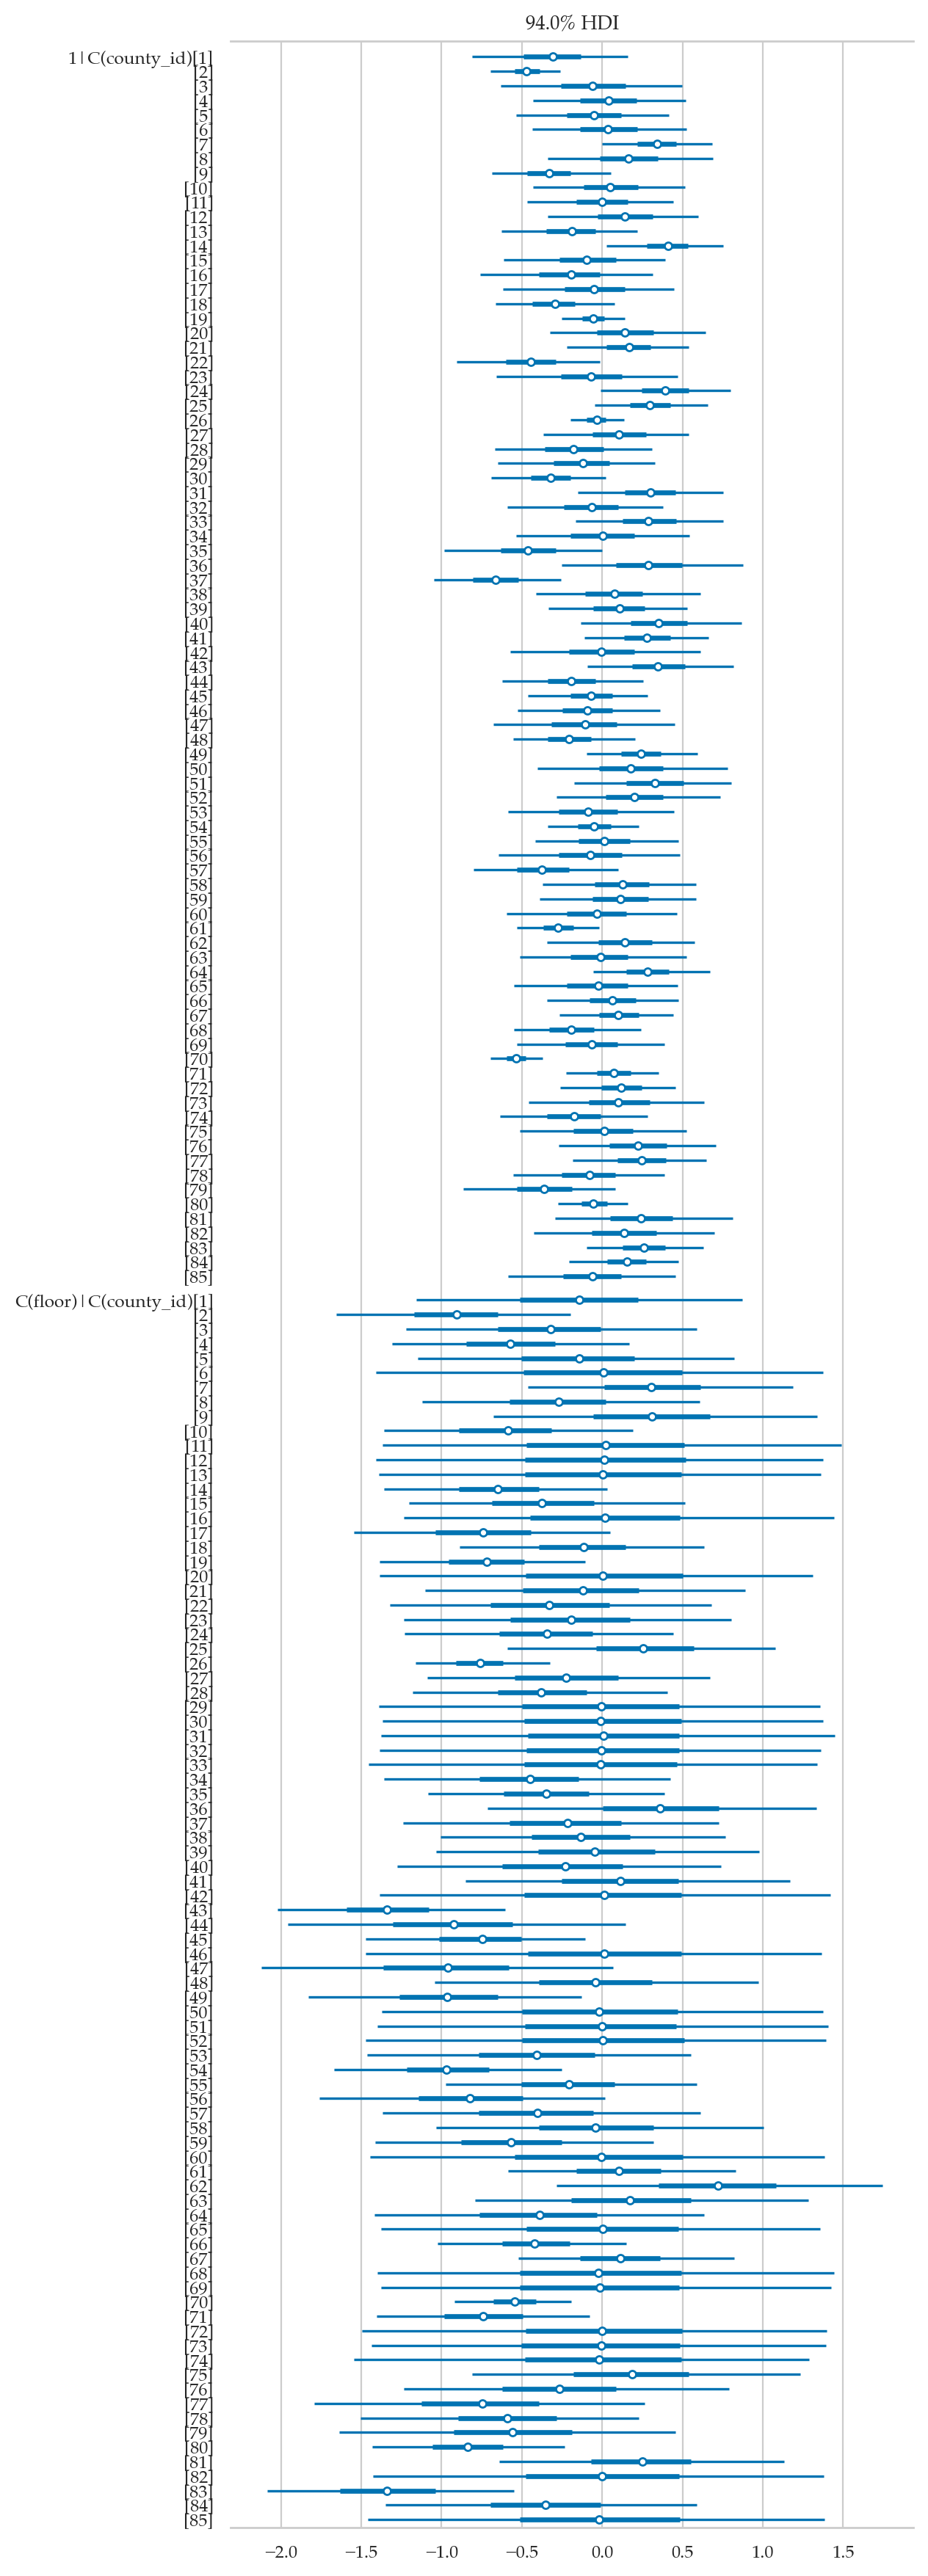

In [21]:
az.plot_forest(idata_pp2, var_names=["1|C(county_id)", "C(floor)|C(county_id)"], combined=True);